In [1]:
"""
    > This script was written by Kyle Gillett (@wxkylegillett) (2022) and modified for BUFR files by Janfisch
"""
# IMPORTS ----------------------------------------------------------------------------------------------------
# Basic Software
#import warnings                                                                  
#warnings.filterwarnings("ignore")    
import pandas           as pd
import numpy            as np
import numpy.ma         as ma
import math
# Matplotlib software
import matplotlib.pyplot as plt
import matplotlib.lines  as mlines
# time software
#from dateutil           import tz
#from timezonefinder     import TimezoneFinder
from datetime           import datetime, timedelta
# Metpy software 
import metpy.calc       as mpcalc
from metpy.plots        import add_metpy_logo, add_unidata_logo, add_timestamp, SkewT, Hodograph
from metpy.units        import units
# siphon software
#from siphon.simplewebservice.wyoming import WyomingUpperAir
# sharppy software
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils 
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo
import sharppy.sharptab.constants as const

#from pybufrkit.decoder import Decoder
import pdbufr  # for reading BUFR files
print("[+] IMPORTS COMPLETE")

from ecape.calc import calc_ecape 

[+] IMPORTS COMPLETE


In [2]:
### get input sounding file
# from BUFR raw sounding file
#BUFRfile="bufr309057_all_20230704_1059_2.bfr"
BUFRfile="/home/jfischer/KITCUBEmount/sftp-upload/RASO/VS/bufr309057_all_20230710_1100_0.bfr"
#BUFRfile="bufr309057_all_20230705_1059_0.bfr"
meta = pdbufr.read_bufr(BUFRfile, columns=("latitude", "longitude","year","month","day","hour","minute","heightOfStationGroundAboveMeanSeaLevel"))
df = pdbufr.read_bufr(BUFRfile, 
    columns=("pressure","nonCoordinateGeopotentialHeight","airTemperature","dewpointTemperature","windDirection","windSpeed", "timePeriod"))
# remove first row if nan (needed for BUFR files)
df=df.loc[~(np.isnan(df.timePeriod) & (df.pressure==100000))]

In [3]:
# USER DATA------------------------------
your_name = 'J. Fischer'  # add your name here to add it to the plot!
city= "Köstlach"
utc_year  = str(int(meta.values[0][0]))          # launch year                          
utc_month = str(int(meta.values[0][1]))            # launch month
utc_day   = str(int(meta.values[0][2]))           # launch day
utc_hour  = str(int(meta.values[0][3]))           # launch hour 
utc_min  = str(int(meta.values[0][4]))
utc_date = datetime(int(utc_year), int(utc_month), int(utc_day), int(utc_hour), int(utc_min))  # create datetime object with UTC launch data
utc_date = utc_date.replace(second=0, microsecond=0, minute=0, hour=utc_date.hour)+timedelta(hours=utc_date.minute//30)  # round launch time to nearest hour

In [7]:
BUFRfile.split("/")[-1][-3:]

'bfr'

In [99]:
stn_elevation_m

array([455.]) <Unit('meter')>

In [128]:
# PARSE PRESSURE, TEMPERATRUE, DEWPOINT, WIND, HEIGHT, ETC FROM THE DATA FRAME        
p1     = df['pressure'].values    * units.Pa      # parse raw pressure array 
T1     = df['airTemperature'].values * units.degK   # parse raw temperature array
Td1    = df['dewpointTemperature'].values    * units.degK      # parse raw dewpoint array
wd1    = df['windDirection'].values   * units.degrees                    # parse raw wind direction array
ws1    = df['windSpeed'].values       * units.meter_per_second        # parse raw wind speed array
u1, v1 = mpcalc.wind_components(ws1, wd1)                            # calc raw u and v wind components 
hgt1   = df['nonCoordinateGeopotentialHeight'].values * units.m            # parse raw height values 
lat    = meta['latitude'].values[0]                                              # parse station lat
lon    = meta['longitude'].values[0]                                          # parse station lon
stn_elevation_m  = np.round(meta.heightOfStationGroundAboveMeanSeaLevel.values)* units.m         # parse stn elevation (m)
z_AGL  = hgt1 - stn_elevation_m              # parse and calc raw height AGL array
#stn_elevation_ft = np.round((stn_elevation_m).to(units.ft),1)        # calculate stn elevation (ft)

# FIX DUPLICATE VALUES & NaNs FOR BETTER CALCULATIONS
non_dups = np.concatenate(([True], np.diff(p1) != 0))
p    = p1[non_dups].to(units.hPa)
T    = T1[non_dups].to(units.degC)
Td   = Td1[non_dups].to(units.degC)
hgt1 = hgt1[non_dups]
z_AGL= z_AGL[non_dups]
ws   = ws1[non_dups]
wd   = wd1[non_dups]
u    = u1[non_dups]
v    = v1[non_dups]

ws   = np.nan_to_num(ws, nan=0*units.meter_per_second)
wd   = np.nan_to_num(wd, nan=0*units.degrees)
u    = np.nan_to_num(u, nan=0*units.meter_per_second)
v    = np.nan_to_num(v, nan=0*units.meter_per_second)
hgt = np.nan_to_num(hgt1, nan=(hgt1[-2]+100*units.m)) # often times final hgt value is nan but its unused data, so a 'rigged fix' is used to put it through calcs without error
p    = np.nan_to_num(p, nan=0*units.hPa)
z_AGL = np.nan_to_num(z_AGL, nan=(z_AGL[-2]+100*units.m))
p30min=np.interp(30*60,df.timePeriod.values,p.m)*units.hPa # JANFISCH, height after 30 min


In [115]:
np.interp([1000],z_AGL.m,p.m)

array([857.09])

In [71]:
u0

2.630799174920135

In [130]:
######################################### SHARRPY AND BASIC VALUE CALCULATIONS ##############################################
# SHARPPY GENERAL & CONVECTIVE PROFILE CREATION
try:
    prof = profile.create_profile(profile='default', pres=p.m, hght=z_AGL.m, tmpc=T.m, \
                                    dwpc=Td.m, wspd=ws, wdir=wd, missing=-9999, strictQC=True)
    #convect_prof = sharppy.sharptab.profile.ConvectiveProfile(pres=p.m, hght=z_AGL.m, tmpc=T.m, 
    #                                dwpc=Td.m, wspd=ws, wdir=wd)#, location=station, date=utc_date)
    sharppyFailed = False 
except:
    print("[*] SHARPPY FAILED")
    sharppyFailed = True
    pass

# CALCULATE OTHER VALUES-------------------------------
Tw = mpcalc.wet_bulb_temperature(p, T, Td)             # WETBULB TEMP
q = mpcalc.specific_humidity_from_dewpoint(p, Td)      # SPECIFIC HUMIDITY
w = mpcalc.mixing_ratio_from_specific_humidity(q)      # MIXING RATIO
Tv = mpcalc.virtual_temperature(T, w)                  # VIRTUAL TEMP
T_degF = np.round(T.to(units.degF), 1)                 # CONVERT T TO DEGF
Td_degF = np.round(Td.to(units.degF), 1)               # CONVERT TD TO DEGF
theta = np.round(mpcalc.potential_temperature(p, T),1) # THETA
theta_e = np.round(mpcalc.equivalent_potential_temperature(p, T, Td),1)   # THETA E

#CALCULATE SPECIAL PARAMETERS 
pwat = np.round(mpcalc.precipitable_water(p, Td), 1)           # calc & round PWAT
r = mpcalc.relative_humidity_from_dewpoint(T, Td)                       # calculate r
RH = np.round((r*100),1)                                                # calculate RH from r
w_raw = mpcalc.mixing_ratio_from_relative_humidity(p, T, r)             # calculate mixing ratio
w = np.round((w_raw*1000),1)*units.g/units.kg                           # convert to g/kg and define units
mean_w = np.round(sum(w)/len(w), 1)                                     # find mean mixing ratio

roseDirection = mpcalc.angle_to_direction(wd[0], full=False, level=3)   # calculate compass rose direction
print("[+] GENERAL CALCULATIONS COMPLETE")



############################################## PARCEL PROPERTIES ############################################################
if sharppyFailed == False:
    # SURFACE PARCEL ----------------------------------------------------------------------------------------------
    sbpcl = params.parcelx(prof, flag=1, pres=p[0].m, tmpc=T[0].m, dwpc=Td[0].m)          # create sfc parcel object
    sbT_trace = sbpcl.ttrace*units.degC                                                   # create sfc parcel T trace 
    sbP_trace = sbpcl.ptrace*units.hPa 
    sb_lcl_p   = int(sbpcl.lclpres) *units.hPa                                            # calc SB LCL (hPa)
    sb_lcl_hgt = int(sbpcl.lclhght) *units.m                                              # calc SB LCL (m) 
    try:                                                                                  # try SHARPPY height calcs 
        sb_lfc_p   = int(sbpcl.lfcpres) *units.hPa                                        # calc SB LFC (hPa)
        sb_lfc_hgt = int(sbpcl.lfchght) *units.m                                          # calc SB LFC (m)
        sb_el_p    = int(sbpcl.elpres ) *units.hPa                                        # calc SB EL(hPa)
        sb_el_hgt  = int(sbpcl.elhght ) *units.m                                          # calc SB EL (m)
        #sb_mpl_hgt = int(sbpcl.mplhght) *units.m                                          # calc SB MPL (m)
    except:                                                                               # upon failure, set all to NaN
        sb_lfc_p         =  float("NaN")*units.hPa                                        # set SB LFC p to 'Nan' 
        sb_lfc_hgt       =  float("NaN")*units.m                                          # set SB LFC m to 'Nan' 
        sb_el_p          =  float("NaN")*units.hPa                                        # set SB EL p to 'Nan'
        sb_el_hgt        =  float("NaN")*units.m                                          # set SB EL m to 'Nan'
        sb_mpl_hgt       =  float("NaN")*units.m                                          # set SB MPL m to 'Nan'
        pass
    # buoyancy 
    sbcape  = int(sbpcl.bplus)                                                            # calc SBCAPE
    sbcin   = int(sbpcl.bminus)                                                           # calc SBCIN
    sb3cape = int(sbpcl.b3km)                                                             # calc SB 3CAPE
    sb6cape = int(sbpcl.b6km)                                                             # calc SB 6CAPE
    sb_li    = int(sbpcl.li5) 
                                                      

    # MIXED PARCEL ------------------------------------------------------------------------------------------------
    depth = (p[0].m - interp.pres(prof, interp.to_msl(prof, 1000)))*units.hPa             # calculate mixed layer depth
    mlpcl_p, mlpcl_T, mlpcl_Td = mpcalc.mixed_parcel(p, T, Td, depth=depth)[0:3]          # create METPY mixed parcel lvl
    mlpcl = params.parcelx(prof, flag=5, pres=mlpcl_p.m, tmpc=mlpcl_T.m, dwpc=mlpcl_Td.m) # create SHARPPY mixed parcel object    
    #try:
    mlT_trace = mlpcl.ttrace.tolist()*units.degC                                          # define mixed parcel T trace 
    mlP_trace = mlpcl.ptrace.tolist()*units.hPa                                           # define mixed parcel P trace 
    ml_lcl_p   = int(mlpcl.lclpres) *units.hPa                                            # calc ML LCL (hPa)
    ml_lcl_hgt = int(mlpcl.lclhght) *units.m                                              # calc ML LCL (m)                                                                                   # try sharppy height calcs 
    try:                                                                                  # try sharppy height calcs 
        ml_lfc_p   = int(mlpcl.lfcpres) *units.hPa                                        # calc ML LFC (hPa)
        ml_lfc_hgt = int(mlpcl.lfchght) *units.m                                          # calc ML LFC (m)
        ml_el_p    = int(mlpcl.elpres ) *units.hPa                                        # calc ML EL (hPa)
        ml_el_hgt  = int(mlpcl.elhght ) *units.m                                          # calc ML EL (m)
    except:                                                                               # upon failure, set heights = NaN
        ml_lfc_p         =  float("NaN") *units.hPa                                       # set to NaN 
        ml_lfc_hgt       =  float("NaN") *units.m                                         # set to NaN 
        ml_el_p          =  float("NaN") *units.hPa                                       # set to NaN
        ml_el_hgt        =  float("NaN") *units.m                                         # set to NaN
        pass
    # buoyancy 
    mlcape  = int(mlpcl.bplus)                                                            # calc MLCAPE 
    mlcin   = int(mlpcl.bminus)                                                           # calc MLCIN
    ml3cape = int(mlpcl.b3km)                                                             # calc ML 3CAPE
    ml6cape = int(mlpcl.b6km)                                                             # calc ML 6CAPE 
    ml_li   = int(mlpcl.li5)                                                              # calc ML LI

    p_ML03, T_ML03 = mpcalc.get_layer(mlP_trace, mlT_trace, depth=3*units.km)             # get_layer for 0-3km ML parcel
    p_ML06, T_ML06 = mpcalc.get_layer(mlP_trace, mlT_trace, depth=6*units.km)             # get_layer for 0-6km ML parcel

    


    # MOST UNSTABLE PARCEL ---------------------------------------------------------------------------------------
    mupcl_p, mupcl_T, mupcl_Td = mpcalc.most_unstable_parcel(p, T, Td, depth=depth)[0:3]
    mupcl = params.parcelx(prof, flag=3, pres=mupcl_p.m, tmpc=mupcl_T.m, dwpc=mupcl_Td.m)
    muT_trace = mupcl.ttrace*units.degC
    muP_trace = mupcl.ptrace*units.hPa
    mu_lcl_p   = int(mupcl.lclpres) *units.hPa
    mu_lcl_hgt = int(mupcl.lclhght) *units.m
    try:                                                                                  # try sharppy height calcs 
        mu_lfc_p   = int(mupcl.lfcpres) *units.hPa                                        # calc ML LFC (hPa)
        mu_lfc_hgt = int(mupcl.lfchght) *units.m                                          # calc ML LFC (m)
        mu_el_p    = int(mupcl.elpres ) *units.hPa                                        # calc ML EL (hPa)
        mu_el_hgt  = int(mupcl.elhght ) *units.m                                          # calc ML EL (m)
    except:                                                                               # upon failure, set heights = NaN
        mu_lfc_p         =  float("NaN") *units.hPa                                       # set to NaN 
        mu_lfc_hgt       =  float("NaN") *units.m                                         # set to NaN 
        mu_el_p          =  float("NaN") *units.hPa                                       # set to NaN
        mu_el_hgt        =  float("NaN") *units.m                                         # set to NaN
        pass
    # buoyancy 
    mucape  = int(mupcl.bplus)
    mu_cape = mupcl.bplus
    mucin   = int(mupcl.bminus)
    mu3cape = int(mupcl.b3km)
    mu6cape = int(mupcl.b6km)
    mu_li   = int(mupcl.li5)   
      
    
    if math.isnan(mu_lfc_hgt.m) == False:
        try:
            mu_ncape = np.round(mucape / ((mu_el_hgt.m - mu_lfc_hgt.m)),1)                      # calculate normalized MUCAPE
            sb_ncape = np.round(sbcape / ((sb_el_hgt.m - sb_lfc_hgt.m)),1)                      # calculate normalized SBCAPE
            ml_ncape = np.round(mlcape / ((ml_el_hgt.m - ml_lfc_hgt.m)),1)                      # calculate normalized MLCAPE
        except:                                                                                 # upon failure, set = '-'
            mu_ncape = '-'
            sb_ncape = '-'
            ml_ncape = '-'
            pass
    else:
        mu_ncape = '-'
        sb_ncape = '-'
        ml_ncape = '-'

    ## ECAPE 
    cape_type = 'most_unstable'
    ecape = calc_ecape(z_AGL, p, T, q, u, v, cape_type)
    
    print("[+] PARCEL AND THERMODYNAMIC CALCULATIONS COMPLETE")
    
    

# FREEZING POINT CALCULATION------------------------------------------------------------------                                                                    
T_list = T.m.tolist()                                                                  # convert T to list to filter 
res = list(filter(lambda i: i <= 0, T_list))[0]                                        # filter T for 0 degC
frz_pt_index = T_list.index(res)                                                       # define pt where T = 0 degC
frz_pt_p = p[frz_pt_index]                                                             # find pres @ T = 0 degC 
frz_pt_z = hgt[frz_pt_index]                                                           # find height @ T = 0 degC
frz_pt_ft = frz_pt_z.to('ft')               
print('[+] FREEZING POINT CALCULATIONS COMPLETE')

# HAIL GROWTH ZONE CALCULATIONS ---------------------------------------------------------------
hgz = params.hgz(prof)
hgz_deltaz = np.round((interp.hght(prof, hgz[1])-interp.hght(prof, hgz[0])),1)*units.m
pHGZ, tHGZ = mpcalc.get_layer(p, T, bottom=hgz[0]*units.hPa, depth=(hgz[0]-hgz[1])*units.hPa)

# PBL TOP CALCULATION--------------------------------------------------------------------------
pbl_top = params.pbl_top(prof)                                                         # calc SHARPPY PBL top height

#  -------------------------------------------- KINEMATIC CALCULATIONS -------------------------------------------------

# EFFECTIVE INFLOW LAYER CALCULATIONS -----------------------------------------------------------
srwind = params.bunkers_storm_motion(prof)
eff_inflow = params.effective_inflow_layer(prof)
ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1])) 
eff_layer = (etop_hght - ebot_hght)
effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])*(units.meter*units.meter)/(units.sec*units.sec)
if np.isnan(effective_srh[0]) == True:
        effective_SRH = 'nan'
if np.isnan(effective_srh[0]) == False:
        effective_SRH = int(effective_srh[0].m)      
try:
    EILshr_u, EILshr_v = mpcalc.bulk_shear(p, u,v, z, 
                                       bottom =(ebot_hght + z[0].m + 20)*units.m, 
                                       depth=(etop_hght - ebot_hght)*units.m)
    effective_bs = int((np.sqrt(EILshr_u**2 + EILshr_v**2)))
except:
    effective_bs = 'nan'
    pass
if ma.is_masked(eff_layer) == True:
    eff_layer = 0
    
#MEAN SHEAR -------------------------------------------------------------------------
#calculate Bulk Shear for 0-1km, 0-3km, 0-6km, 0-8km.
u_shear005, v_shear005 = mpcalc.bulk_shear(p, u, v, depth = 500 * units.meter)
shear005 = np.round((np.sqrt(u_shear005**2 + v_shear005**2)), 1)
u_shear01, v_shear01 = mpcalc.bulk_shear(p, u, v, depth = 1000 * units.meter)
shear01 = np.round((np.sqrt(u_shear01**2 + v_shear01**2)), 1)
u_shear03, v_shear03 = mpcalc.bulk_shear(p, u, v, depth = 3000 * units.meter)
shear03 = np.round((np.sqrt(u_shear03**2 + v_shear03**2)), 1)
u_shear06, v_shear06 = mpcalc.bulk_shear(p, u,v, depth = 6000 * units.meter)
shear06 = np.round((np.sqrt(u_shear06**2 + v_shear06**2)), 1)

RM_u=np.nan
if ma.is_masked(RM_u) == True or np.isnan(RM_u) == True or sharppyFailed == True:
    RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, hgt)
    MW_u = MW[0]
    MW_v = MW[1] 
    RM_u = RM[0]
    RM_v = RM[1]
    LM_u = LM[0]
    LM_v = LM[1]
    MW_u = MW[0]
    MW_v = MW[1]    
    print("[*] METPY BUNKERS USED")
    
# RM STORM RELATIVE HELICITY -----------------------------------------------------------
# calculate and round positive, negative and total SRH for 0-1km, 0-3km, and 0-6km.
srh_005_pos, srh_005_neg, srh_005_tot = mpcalc.storm_relative_helicity(hgt, u, v, 500 * units.meter, bottom = hgt[0], storm_u = RM_u, storm_v = RM_v)
srh_005 = np.round(srh_005_pos, 1)

srh_01_pos, srh_01_neg, srh_01_tot = mpcalc.storm_relative_helicity(hgt, u, v, 1000 * units.meter, bottom = hgt[0], storm_u = RM_u, storm_v = RM_v)
srh_01 = np.round(srh_01_pos, 1)
srh_03_pos, srh_03_neg, srh_03_tot = mpcalc.storm_relative_helicity(hgt, u, v, 3000 * units.meter, bottom = hgt[0], storm_u = RM_u, storm_v = RM_v)
srh_03 = np.round(srh_03_pos, 1)
srh_06_pos, srh_06_neg, srh_06_tot = mpcalc.storm_relative_helicity(hgt, u, v, 6000 * units.meter, bottom = hgt[0], storm_u = RM_u, storm_v = RM_v)
srh_06 = np.round(srh_06_pos, 1)

# METPY SEVERE PARAMETERS -----------------------------------------------------------------
KI = mpcalc.k_index(p, T, Td)                                           # calc K Index
TT = np.round(mpcalc.total_totals_index(p, T, Td), 1)                   # calc & round TT
showalter_index = np.round(mpcalc.showalter_index(p, T, Td), 1)         # calc & round showalter

if sharppyFailed == False:
    u0, v0 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 0))) * units.kts
    sru0 = u0.to(units.meter_per_second) - RM_u
    srv0 = v0.to(units.meter_per_second) - RM_v
    sr0_speed = mpcalc.wind_speed(sru0, srv0)
    sr0_speed = mpcalc.wind_speed(sru0, srv0)

    u05, v05 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 500))) * units.kts
    sru05 = u05.to(units.meter_per_second) - RM_u
    srv05 = v05.to(units.meter_per_second) - RM_v
    sr05_speed = mpcalc.wind_speed(sru05, srv05)
    
    u1, v1 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 1000)))* units.kts
    sru1 = u1.to(units.meter_per_second) - RM_u
    srv1 = v1.to(units.meter_per_second) - RM_v
    sr1_speed = mpcalc.wind_speed(sru1, srv1)
    
    u3, v3 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 300)))* units.kts
    sru3 = u3.to(units.meter_per_second) - RM_u
    srv3 = v3.to(units.meter_per_second) - RM_v
    sr3_speed = mpcalc.wind_speed(sru3, srv3)

    u6, v6 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 6000)))* units.kts
    sru6 = u6.to(units.meter_per_second) - RM_u
    srv6 = v6.to(units.meter_per_second) - RM_v
    sr6_speed = mpcalc.wind_speed(sru6, srv0)
    sr6_speed = mpcalc.wind_speed(sru6, srv0)

    u9, v9 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 9000)))* units.kts
    sru9 = u9.to(units.meter_per_second) - RM_u
    srv9 = v9.to(units.meter_per_second) - RM_v
    sr9_speed = mpcalc.wind_speed(sru9, srv9)

    sfc500m_SRwind = (sr05_speed + sr0_speed)/2
    sfc1000m_SRwind = (sr1_speed + sr0_speed)/2
    sfc3000m_SRwind = (sr3_speed + sr0_speed)/2
    sfc6000m_SRwind = (sr6_speed + sr0_speed)/2
    
if sharppyFailed == True: 
    sfc500m_SRwind = -999
    sixToNine_SRwind = -999

# VORTICITY CALCULATIONS 
# interpolate function to intrp u and v data for clean plotting w/ hgt
def interpolate(var,hgts,step):
        levels=np.arange(0,np.max(hgts),step)
        varinterp=np.zeros(len(levels))
        for i in range(0,len(levels)):
            lower=np.where(hgts-levels[i]<=0,hgts-levels[i],-np.inf).argmax()
            varinterp[i]=(((var[lower+1]-var[lower])/(hgts[lower+1]-hgts[lower]))*(levels[i]-hgts[lower])+var[lower])
        return varinterp 
    
resolution=100
pINTRP=p.m[np.isnan(hgt)==False]
uINTRP=u.m[np.isnan(hgt)==False]
vINTRP=v.m[np.isnan(hgt)==False]
zINTRP=hgt.m[np.isnan(hgt)==False]
zINTRP=zINTRP-zINTRP[0]
# Interpolation
pINTRP=interpolate(pINTRP,zINTRP,resolution)
uINTRP=interpolate(uINTRP,zINTRP,resolution)
vINTRP=interpolate(vINTRP,zINTRP,resolution)
zINTRP=interpolate(zINTRP,zINTRP,resolution)

u_ms = uINTRP/1.94384
v_ms = vINTRP/1.94384

uSR = (uINTRP*units.meter_per_second - RM_u)/1.94384
vSR = (vINTRP*units.meter_per_second - RM_v)/1.94384


# Shear components
dudz=(u_ms[2::]-u_ms[0:-2])/(zINTRP[2::]-zINTRP[0:-2])
dvdz=(v_ms[2::]-v_ms[0:-2])/(zINTRP[2::]-zINTRP[0:-2])
dudz=np.insert(dudz,0,dudz[0])
dudz=np.insert(dudz,-1,dudz[-1])
dvdz=np.insert(dvdz,0,dvdz[0])
dvdz=np.insert(dvdz,-1,dvdz[-1])
# Shear magnitude
shear=np.sqrt(dudz**2+dvdz**2)+0.0000001
# Vorticity components
uvort=-dvdz
vvort=dudz
# Streamwise vorticity
strmw=abs((uSR*uvort+vSR*vvort)/(np.sqrt(uSR**2+vSR**2)))
# Streamwise fraction
strmwperc=(strmw/shear)*100

# layer average streamwise vorticity and SW vort %
strmwperc_05 = np.mean(strmwperc[0:5])
strmwperc_01 = np.mean(strmwperc[0:10])
strmwperc_03 = np.mean(strmwperc[0:30])
strmw_05 = np.mean(strmw[0:5])
strmw_01 = np.mean(strmw[0:10])
strmw_03 = np.mean(strmw[0:30])

print('[+] SHEAR CALCULATIONS COMPLETE')
    
# MEAN RELATIVE HUMIDITY CALCULATIONS ----------------------------------------------------------
RH0_05 = sharppy.sharptab.params.mean_relh(prof, pbot=interp.pres(prof, interp.to_msl(prof, 0000)), ptop=interp.pres(prof, interp.to_msl(prof, 500)))
RH0_1  = sharppy.sharptab.params.mean_relh(prof, pbot=interp.pres(prof, interp.to_msl(prof, 0000)), ptop=interp.pres(prof, interp.to_msl(prof, 1000)))
RH1_3 = sharppy.sharptab.params.mean_relh(prof, pbot=interp.pres(prof, interp.to_msl(prof, 1000)), ptop=interp.pres(prof, interp.to_msl(prof, 3000)))
try: #for lack of data with height 
    RH3_6 = sharppy.sharptab.params.mean_relh(prof, pbot=interp.pres(prof, interp.to_msl(prof, 3000)), ptop=interp.pres(prof, interp.to_msl(prof, 6000)))
    RH6_9= sharppy.sharptab.params.mean_relh(prof, pbot=interp.pres(prof, interp.to_msl(prof, 6000)), ptop=interp.pres(prof, interp.to_msl(prof, 9000)))
except ValueError:
    pass
print('[+] RH CALCULATIONS COMPLETE')
print('____________________________')

[+] GENERAL CALCULATIONS COMPLETE
[+] PARCEL AND THERMODYNAMIC CALCULATIONS COMPLETE
[+] FREEZING POINT CALCULATIONS COMPLETE
[*] METPY BUNKERS USED
[+] SHEAR CALCULATIONS COMPLETE
[+] RH CALCULATIONS COMPLETE
____________________________


'bufr309057_all_20230704_1059_2.'

[+] SKEW T OBJECT CREATION COMPLETE
[+] BASIC SKEW-T PLOTTING COMPLETE
[+] SKEW-T ANNOTATIONS COMPLETE
[+] HODOGRAPH CREATION & PLOTTING COMPLETE
_______________________________________
The sounding is now loading. This may take a second, especially if you plotted reports and/or tornado tracks.


/tmp/ipykernel_28270/3618874551.py:297: UserWarning: Legend does not support handles for Text instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  skewleg1 = skew.ax.legend(loc='upper left')


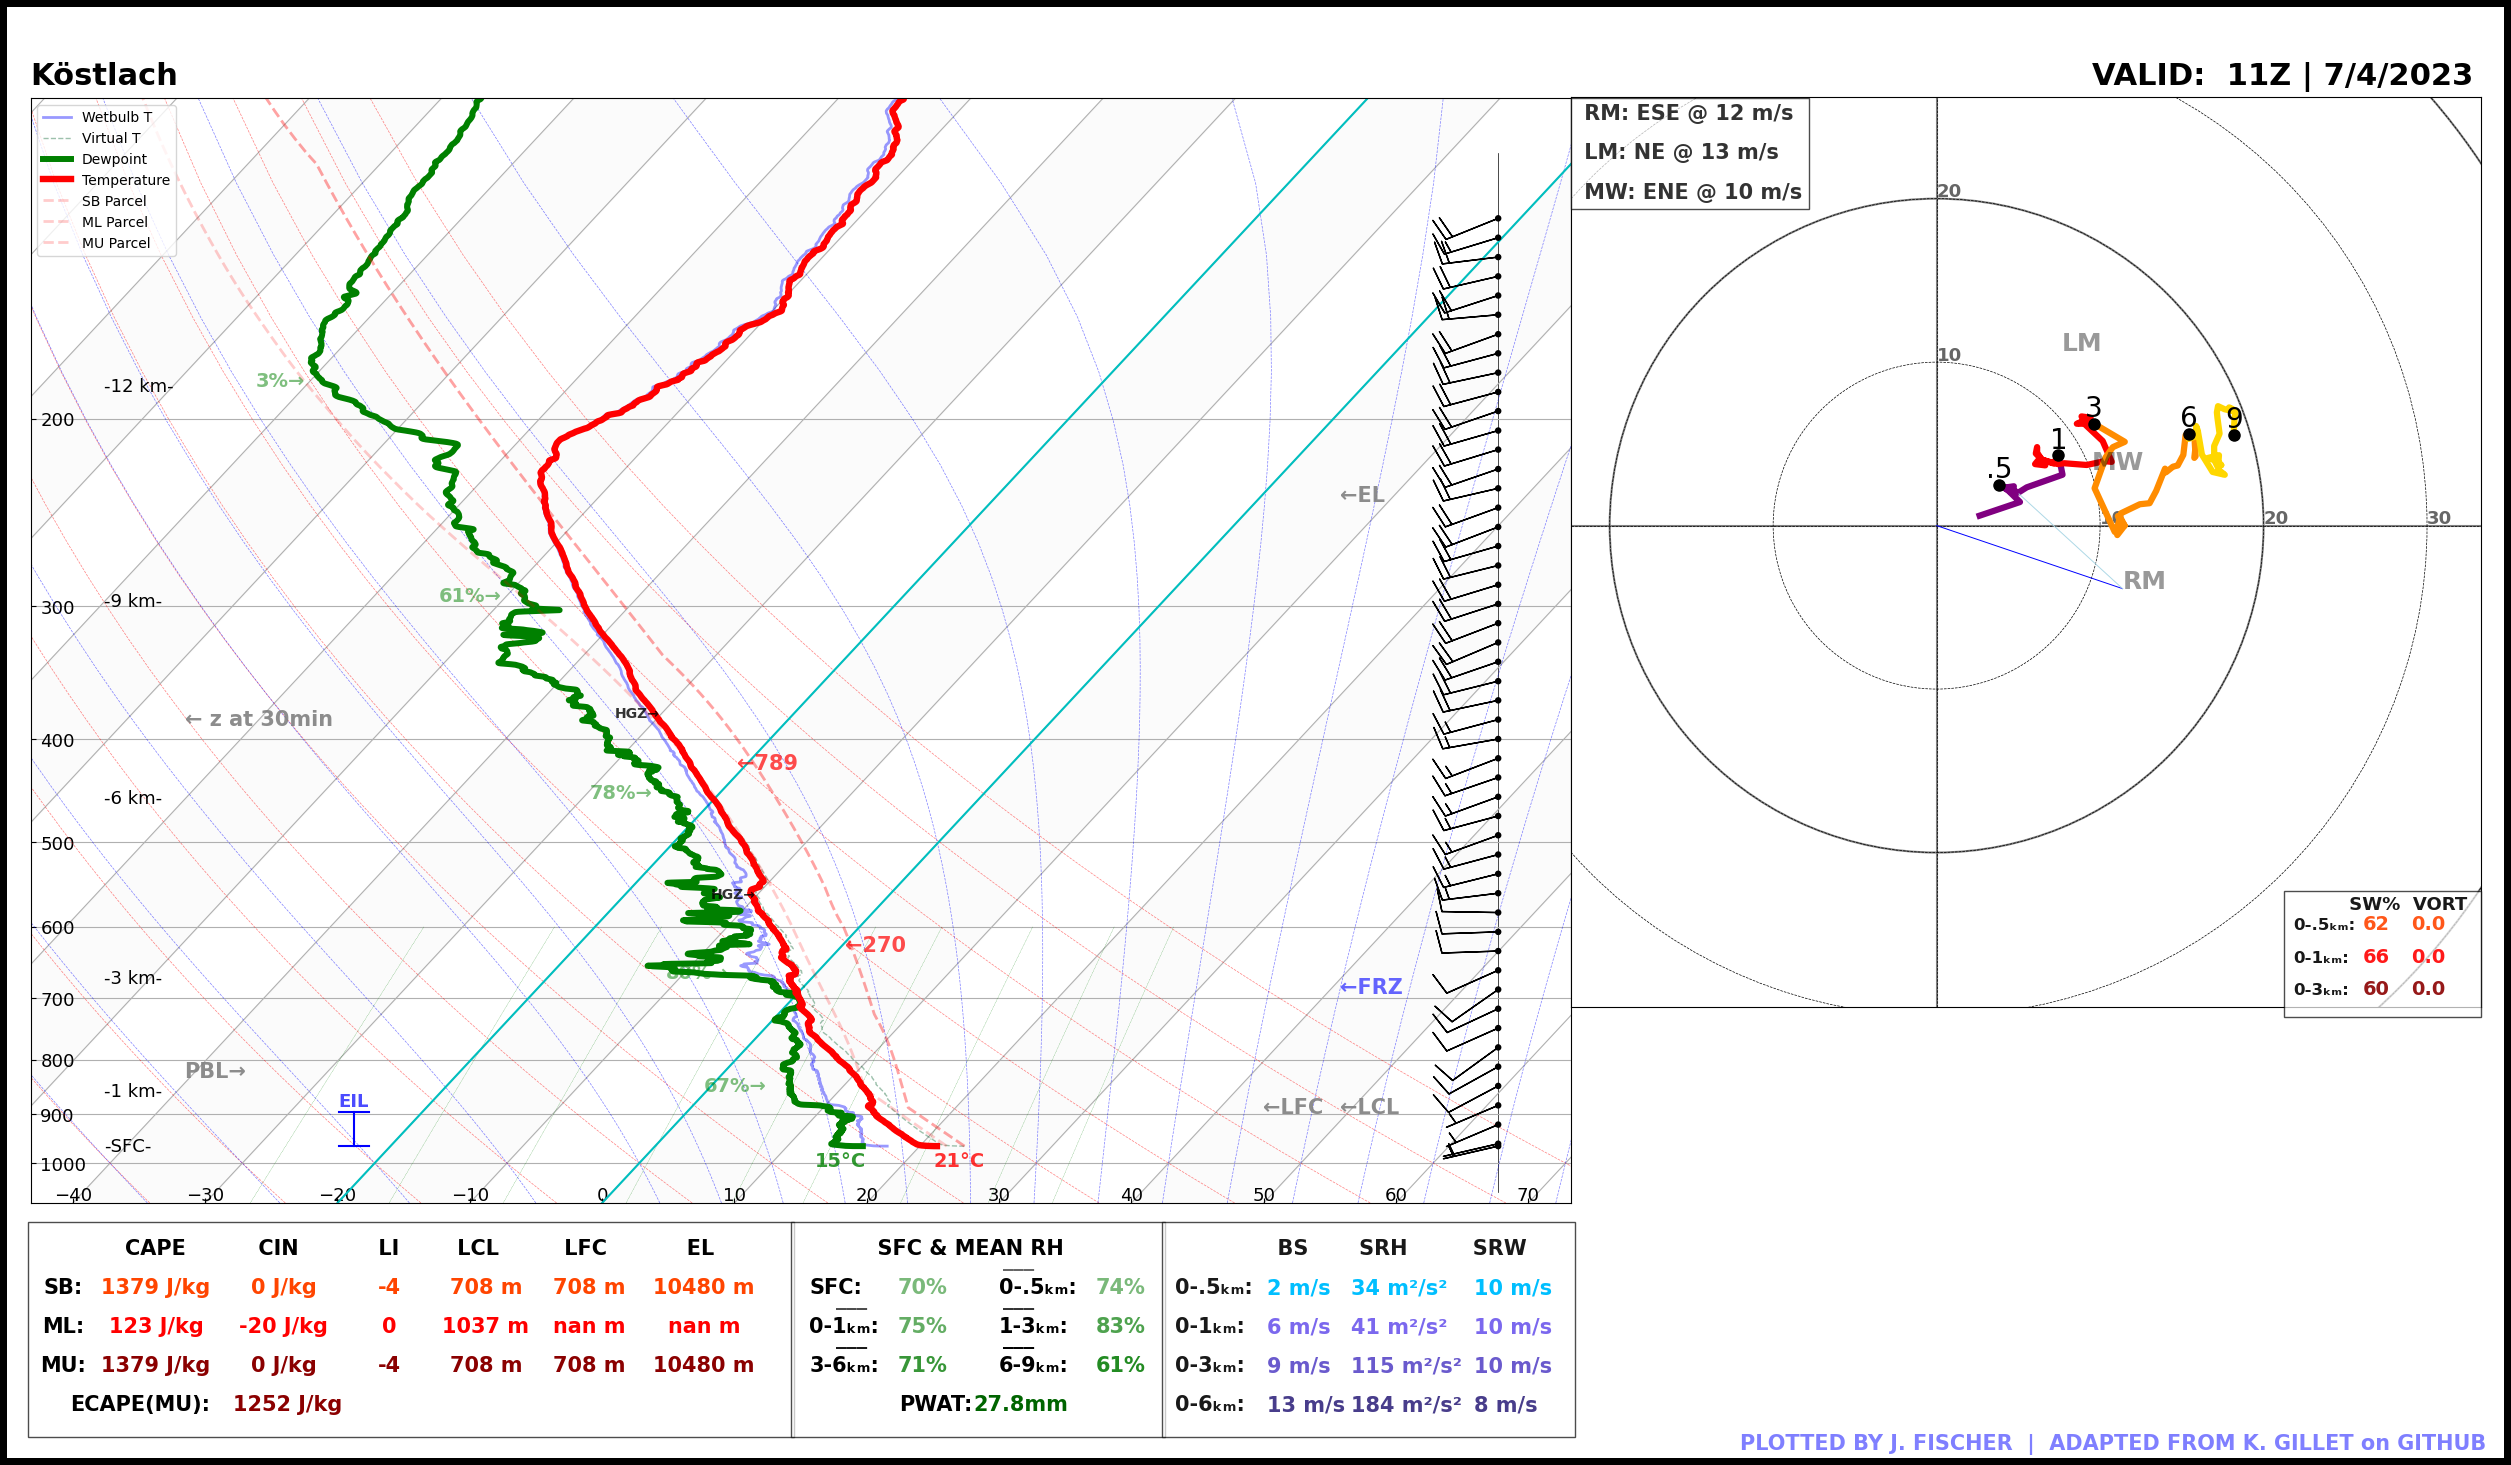

In [127]:
###################################### FIGURE CREATION and SKEW T PROPERTIES ################################################
#CREATE FIGURE-----------------------------------------------------------------------------------
fig = plt.figure(figsize=(22,13), linewidth=10, edgecolor="black")             # create figure                                   # create figure
skew = SkewT(fig, rotation=43, rect=(0.1, 0.1, 0.70, 0.85))                    # create SkewT Object
#AXIS LIMITS ------------------------------------------------------------------------------------
# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')                                             # allow for datalim adjustments 
skew.ax.set_ylim(1090, 100)                                                   # y axis (pressure hPa) limits                                         
skew.ax.set_xlim(-40, 70)                                                     # x axis (degrees C) limits
plt.xticks(fontsize=13)                                                       # define x axis tick mark size
plt.yticks(fontsize=13, ha='left')                                            # define y axis tick mark size
plt.tick_params(axis="x",direction="in", pad=-12)                             # set x tick params 
plt.tick_params(axis="y",direction="in", pad=-7)                              # set y tick params
skew.ax.set_yticks([1000, 900, 800, 700, 600, 500, 400, 300, 200])            # declare lables for x axis 
skew.ax.set_yticklabels([1000, 900, 800, 700, 600, 500, 400, 300, 200])       # declare lables for y axis 
fig.set_facecolor('#ffffff')                                                  # add figure background color #f6f8fd
skew.ax.set_facecolor('#ffffff')                                              # add skew background color                             
plt.xlabel("  ", fontsize=12)                                                 # remove x axis label
plt.ylabel("  ", fontsize=12)                                                 # remove y axis label
#PLOT TITLE--------------------------------------------------------------------------------------
plt.figtext( 0.10, 0.96, f'{city}',
       weight='bold', ha='left', fontsize=22, color='black')
plt.figtext( 1.22, 0.96, f'VALID:  {utc_date.hour}Z | {utc_month}/{utc_day}/{utc_year}  ',
        weight='bold', ha='right', fontsize=22, color='black')
print("[+] SKEW T OBJECT CREATION COMPLETE")
############################################################################################################################

################################################## SKEW-T DATA PLOTTING ####################################################
#PLOTS DATA LINES -------------------------------------------------------------------------------------------
skew.ax.axvline(0 * units.degC, color='c')                                              # highlight zero degrees C isotherm
skew.ax.axvline(-20 * units.degC, color='c')                                            # highlight -20 degrees C isotherm
twline = skew.plot(p, Tw, 'blue', linewidth=2, label='Wetbulb T', alpha=0.4)         # plot wetbulb temperature trace 
tvline = skew.plot(p, Tv, '#0b6431', linestyle='--', linewidth=1, label='Virtual T', alpha=0.4)    # plot virtual temperature trace 
skew.plot_dry_adiabats(color='black', linewidth=0.5)                                    # plot dry adiabats
skew.plot_moist_adiabats(linewidth=0.5)                                                 # plot moist adiabats
skew.plot_mixing_lines(linewidth=0.2)                                                   # plot mixing ratio lines
tdline = skew.plot(p, Td, 'green', linewidth=4.3, label='Dewpoint')                     # plot dewpoint trace 
tline = skew.plot(p, T, 'red', linewidth=4.6, label='Temperature')                      # plot temperature trace 
# PLOT PARCEL LINES -----------------------------------------------------------------------------------------
if sbcape > 0:
    sbparcelline = skew.plot(sbP_trace, sbT_trace, linestyle='--',                    # plot SB parcel trace 
                             linewidth=2, color='red', alpha=0.2, label='SB Parcel')    
if mlcape > 0:
    mlparcelline = skew.plot(mlP_trace, mlT_trace, color='red', linestyle='--',         # plot ML parcel trace
                             linewidth=2, alpha=0.2, label='ML Parcel')               
if mucape > 0:
    muparcelline = skew.plot(muP_trace, muT_trace, color='red', linestyle='--',         # plot MU parcel trace  
                             linewidth=2, alpha=0.2, label='MU Parcel') 
# SHADE ISOTHERMS----------------------------------------------------------------------------------------------
x1 = np.linspace(-100, 40, 8)                                                     # The starting x values for the shaded regions
x2 = np.linspace(-90, 50, 8)                                                      # The ending x values for the shaded regions
y = [1090, 100]                                                                   # The range of y values that the shades regions should cover
for i in range(0, 8):                                                             # shade every 10 degC isotherms
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.03, zorder=1)       

#PLOT HEIGHT (KM) VALUES ON PRESSURE AXIS-----------------------------------------------------------------------
heightsAGL = np.array([1000,3000,6000,9000,12000])*units.m                                   
heights = np.array([1, 3, 6, 9, 12]) * units.km                          # Define what height values to plot
#std_pressures = mpcalc.height_to_pressure_std(heightsAGL)                # calculate height (km) to pressure value  # JANFISCH these are not AGL but standard atmosphere
std_pressures=np.interp(heightsAGL.m,z_AGL.m,p.m)*units.hPa
for height_tick, p_tick in zip(heights, std_pressures):                  # plot heights 
    trans, _, _ = skew.ax.get_yaxis_text1_transform(0)
    skew.ax.text(0.048, p_tick, '-{:~d}-'.format(height_tick), fontsize=13, transform=trans,verticalalignment="center")   # JANFISCH verticalalignment
sfc_p = np.ceil(p[0]) #(p[0].m*(1-(0.0065*(stn_elevation_m[0].m))/(T[0].m+(0.0065*(stn_elevation_m[0].m))+273.15))**-5.257)*units.hPa
skew.ax.text(0.048, sfc_p, '-SFC-', fontsize=13, transform=trans,verticalalignment="center") # plot 'SFC' @ surface pressure

#CREATE AND PLOT WIND BARBS---------------------------------------------------------------------------------------
interval = np.logspace(2.113, 3, 50) * units.hPa                                 # Arrange wind barbs for best fit
idx = mpcalc.resample_nn_1d(p, interval)                                         # Resample wind barbs for best fit
# create blank barbs for small dot at the start of each actual barb
blank_len = len(u[idx])                                                          # find len(u) to create blank barbs         
blank = np.zeros(blank_len)                                                      # fill blank barbs with 0kts 
skew.plot_barbs(pressure=p[idx],u=blank,v=blank,xloc=0.953,fill_empty=True,      # plot empty wind barbs 
                sizes=dict(emptybarb=0.075, width=0.18, height=0.4))
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx],xloc=0.953, fill_empty=True,  # plot actual resampled wind barbs
                sizes=dict(emptybarb=0.075, width=0.18, height=0.4), length=9)

# Draw line underneath wind barbs
line = mlines.Line2D([0.953, 0.953], [0.01,0.95],color='black',linewidth=0.5,    # create line object behind barbs
                     transform=skew.ax.transAxes,clip_on=False,zorder=1)
skew.ax.add_line(line)                                                           # plot the line 

print("[+] BASIC SKEW-T PLOTTING COMPLETE")
#############################################################################################################################

#################################################### ANNOTATIONS  ###########################################################
# MU HEIGHT ANNOTATIONS----------------------------------------------------------------
if math.isnan(mu_lfc_hgt.m) == False:
    plt.text((0.8), (mu_lfc_p), "←LFC", weight='bold',color='gray',               # plot MU LFC
             alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform(),verticalalignment='center')
    plt.text((0.85), (mu_el_p), "←EL", weight='bold',color='gray',                 # plot MU EL
             alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform(), label='Height Label',verticalalignment='center')  #JANFISCH alignment centered

# SB HEIGHT ANNOTATIONS----------------------------------------------------------------- 
plt.text((0.85), (sb_lcl_p), "←LCL", weight='bold',color='gray',                   # plot SB LCL
         alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform(),verticalalignment='center')
if math.isnan(mu_lfc_hgt.m) == True:
    plt.text((0.8), (sb_lfc_p), "←LFC", weight='bold',color='gray',               # plot SB LFC
             alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform(),verticalalignment='center')
    plt.text((0.85), (sb_el_p), "←EL", weight='bold',color='gray',                 # plot SB EL
             alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform(), label='Height Label',verticalalignment='center') 

#FRREZING POINT ANNOTATION--------------------------------------------------------------
if frz_pt_z >= 50*units.m:                                                             # only plot FRZ PT if its above 50m
    plt.text((0.85), (frz_pt_p), "←FRZ", weight='bold',color='blue',                   # plot location where T = 0 degC
             alpha=0.6, fontsize=15, transform=skew.ax.get_yaxis_transform())
    
#SFC TEMPERATURE AND DEWPOINT ANNOTATIONS-----------------------------------------------
T_degF_label = '{}°C'.format(int(T[0].magnitude))                                 # create sfc T degF label 
plt.annotate(T_degF_label, (T[0], p[0]), textcoords="offset points", xytext=(16,-15),  # plot sfc T label (degF)
                 fontsize=14, color='red', weight='bold', alpha=0.8, ha='center')   
Td_degF_label = '{}°C'.format(int(Td[0].magnitude))                               # create sfc Td degF label 
plt.annotate(Td_degF_label,(Td[0], p[0]),textcoords="offset points",xytext=(-16,-15),  # plot sfc Td label (degF)
                 fontsize=14, color='green', weight='bold', alpha=0.8, ha='center') 

#PBL TOP POINT ANNOTATION---------------------------------------------------------------                   
plt.text((0.1), (pbl_top), "PBL→", weight='bold',color='gray',                       # plot location of PBL top hght 
         alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform())

# JANFISCH height after 30min
plt.text((0.1), (p30min), "← z at 30min", weight='bold',color='gray',                       # plot location of PBL top hght 
         alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform())

# 0-3km & 0-6km CAPE ANNOTATIONS---------------------------------------------------------------------------------- 
if ml3cape > 10:
        cape03_label = "←{}".format(mu3cape)                                            
        plt.annotate(cape03_label,  ((T_ML03[-1].m +2), interp.pres(prof, 3000+ hgt[0].m)),  textcoords="offset points",  xytext=(10, 0), 
                     color='red', alpha=0.7, fontsize=15, weight='bold', ha='center')  
if ml6cape > 10:
        cape06_label = "←{}".format(mu6cape)                                            
        plt.annotate(cape06_label,((T_ML06[-1].m + 2), interp.pres(prof, 6000+ hgt[0].m)), textcoords="offset points",  xytext=(10, 0), 
                     color='red', alpha=0.7, fontsize=15, weight='bold', ha='center') 

#RELATIVE HUMIDITY WITH HEIGHT CALCULATIONS AND ANNOTATIONS-------------------------------------------------------
for i in range (0, 5):
    heights = [1000, 3000, 6000, 9000, 12000]
    try:
        intrp_p  = sharppy.sharptab.interp.pres(prof, heights[i])
        intrp_T  = sharppy.sharptab.interp.temp(prof, intrp_p)
        intrp_Td = sharppy.sharptab.interp.dwpt(prof, intrp_p)
        intrp_RH = sharppy.sharptab.thermo.relh(intrp_p, intrp_T, intrp_Td)
        RH_label = "{}%→".format(int(intrp_RH))
        plt.annotate(RH_label, (intrp_Td, intrp_p), textcoords="offset points", xytext=(-40, 0), 
                 color='green', weight='bold', alpha=0.5, fontsize=14, ha='center') 
    except:
        pass
  
# EFFECTIVE INFLOW LAYER ANNOTATION-------------------------------------------------------------------------------
import matplotlib.transforms as mtransforms
x_start, x_end = 0.2, 0.22
x_mid = (x_start + x_end)/2
skew.ax.axhline(eff_inflow[0], xmin=x_start, xmax=x_end, color='blue')
skew.ax.axhline(eff_inflow[1], xmin=x_start, xmax=x_end, color='blue')
plt.text((x_start+0.01), (eff_inflow[1]-10), "EIL", weight='bold',color='blue', alpha=0.7, ha='center', fontsize=13, transform=skew.ax.get_yaxis_transform())
#plt.text((x_start-0.02), (eff_inflow[0]+35), "ESRH: {}".format(np.round(effective_srh[0],1)), color='blue', weight='bold', fontsize=13, alpha=0.7, transform=skew.ax.get_yaxis_transform())
EIL_line = plt.Line2D([x_mid, x_mid], (eff_inflow[0], eff_inflow[1]), color='blue', transform=skew.ax.get_yaxis_transform())
skew.ax.add_artist(EIL_line)
    
#HAIL GROWTH ZONE ANNOTATION------------------------------------------------------------------------------------
plt.annotate(f'HGZ→', (tHGZ[0], hgz[0]*units.hPa), textcoords="offset points", xytext=(-15,0),
                 fontsize=10, color='black', weight='bold', alpha=0.8, ha='center')  
plt.annotate(f'HGZ→', (tHGZ[-1], hgz[1]*units.hPa), textcoords="offset points", xytext=(-15,0),
                 fontsize=10, color='black', weight='bold', alpha=0.8, ha='center')  
print('[+] SKEW-T ANNOTATIONS COMPLETE')
##############################################################################################################################

################################################## HODOGRAPH PLOTTING ########################################################
# define x and y min/max values from 'cleaned' and restructured u and v arrays
x_min = uINTRP[0:90].min()
y_min = vINTRP[0:90].min()
x_max = uINTRP[0:90].max()
y_max = vINTRP[0:90].max()

# if statements to determine approprate x axis and y axis limits (to change dynamically with the data)
if y_max >= 0:
    y_Maxlimit = (y_max + 15)
if y_max < 0:
    y_Maxlimit = (y_max + 15)
    
if x_max >= 0:
    x_Maxlimit = (x_max + 15)
if x_max < 0:
    x_Maxlimit = (x_max + 15)
    
if y_min >= 0:
    y_Minlimit = (y_min - 25)
if y_min < 0:
    y_Minlimit = (y_min - 25)
    
if x_min >= 0:
    x_Minlimit = (x_min - 25)
if x_min < 0:
    x_Minlimit = (x_min - 25)

# CREATE HODOGRAPH OBJECT --------------------------------------------------------------
hod_ax = plt.axes((0.657, 0.2505, 0.70, 0.70))                        # where to position hodo + makes axes

h = Hodograph(hod_ax, component_range=150.)                         # creates hodograph object
h.ax.set_xlim(x_Minlimit, x_Maxlimit)                               # set x axis bounds
h.ax.set_ylim(y_Minlimit, y_Maxlimit)                               # set y axis bounds                                                                          
h.add_grid(increment=20, linestyle='-', linewidth=1.5)              # define 1st hodo grid
h.add_grid(increment=10, color='black', linewidth=0.5)              # define 2nd hodo grid
h.ax.set_facecolor('#ffffff')                                       # hodo background color
h.ax.set_box_aspect(1)                                              # set hodo aspect ratio
h.ax.set_yticklabels([])                                            # remove y tick labels 
h.ax.set_xticklabels([])                                            # remove x tick labels
h.ax.set_xticks([])                                                 # remove x tick marks
h.ax.set_yticks([])                                                 # remove y tick marks
h.ax.set_ylabel(' ')                                                # remove y axis label
h.ax.set_xlabel(' ')                                                # remove x axis label 

# HODOGRAPH COLOR MAPS-------------------------------------------------------------------
colors=['white','gray','lightgray','darkgray',[0.3,0.3,0.3]]        # Brandt Streamwiseness colormap
hodo_color = ['purple','red','darkorange','gold','#fff09f']         # Cameron Nixon height colormap

# PLOT DATA ON HODOGRAPH (CAMERON NIXON PLOT STYLE) -------------------------------------
h.ax.plot(uINTRP[0:10+1], vINTRP[0:10+1], color=hodo_color[0], linewidth=4.5, clip_on=True)
h.ax.plot(uINTRP[10:30+1], vINTRP[10:30+1], color=hodo_color[1], linewidth=4.5, clip_on=True)
h.ax.plot(uINTRP[30:60+1], vINTRP[30:60+1], color=hodo_color[2], linewidth=4.5, clip_on=True)
h.ax.plot(uINTRP[60:90+1], vINTRP[60:90+1], color=hodo_color[3], linewidth=4.5, clip_on=True)
#h.ax.plot(uINTRP[90:120+1], vINTRP[90:120+1], color=hodo_color[4], linewidth=4.5, clip_on=True) 

# function to convert storm motion to useful degrees 
def degrees_calc(degrees):
    if degrees > 180:
        degrees = degrees - 180
    elif degrees <= 180:
        degrees = degrees + 180
    return degrees

# BUNKERS ET AL (2000) SUPERCELL MOTION ----------------------------------------------
# the actual RM/LM/MW values were calculated in the previous cell 
#RIGHT MOVER
rm_pt = [RM_u.magnitude, RM_v.magnitude]                                          # define RM point
x_values = [rm_pt[0], 0]                                                          # define x values for RM vector
y_values = [rm_pt[1], 0]                                                          # define y values for RM vector
h.ax.plot(x_values, y_values, linestyle='-', 
          linewidth=0.7, color='blue', label='Bunkers RM Vector')                 # plot RM vector 
RMdir = mpcalc.wind_direction(RM_u, RM_v).magnitude                               # calc RM wind direction 
RMspd = mpcalc.wind_speed(RM_u, RM_v).magnitude                                   # calc RM wind speed 
RM_roseDir = mpcalc.angle_to_direction((degrees_calc(RMdir))*units.degrees,       # correct SM degrees
                                       full=False, level=3)
# LEFT MOVER
LMdir = mpcalc.wind_direction(LM_u, LM_v).magnitude                               # calc LM wind direction
LMspd = mpcalc.wind_speed(LM_u, LM_v).magnitude                                   # calc LM wind speed
LM_roseDir = mpcalc.angle_to_direction((degrees_calc(LMdir))*units.degrees,       # correct SM degrees
                                       full=False, level=3)                       
# MEAN WIND
meandir = mpcalc.wind_direction(MW_u, MW_v).magnitude                             # calc mean wind direction 
meanspd = mpcalc.wind_speed(MW_u, MW_v).magnitude                                 # calc mean wind speed
MW_roseDir = mpcalc.angle_to_direction((degrees_calc(meandir))*units.degrees,     # correct SM degrees
                                       full=False, level=3)
# BUNKERS STORM MOTION MARKERS 
h.ax.text((RM_u.magnitude), (RM_v.magnitude), 'RM', weight='bold', alpha=0.4, fontsize=18)
h.ax.text((LM_u.magnitude), (LM_v.magnitude), 'LM', weight='bold', alpha=0.4, fontsize=18)
h.ax.text((MW_u.magnitude), (MW_v.magnitude), 'MW', weight='bold', alpha=0.4, fontsize=18)

# THOMPSON ET AL (2007) EFFECTIVE INFLOW LAYER ----------------------------------------------
# the actual EIL data values were calculated in the previous cell 
ebot_componets = sharppy.sharptab.interp.components(prof, sharppy.sharptab.interp.pres(prof, ebot_hght)) # calc wind @ EIL bottom
etop_componets = sharppy.sharptab.interp.components(prof, sharppy.sharptab.interp.pres(prof, etop_hght)) # calc wind @ EIL top
etop_pt = [etop_componets[0], etop_componets[1]]                    # define EIL top pt 
ebot_pt = [ebot_componets[0], ebot_componets[1]]                    # define EIL bottom pt
ebotu_values = [rm_pt[0], ebot_pt[0]]                               # define EIL bottom u & RM u pt
ebotv_values = [rm_pt[1], ebot_pt[1]]                               # define EIL bottom v & RM v pt
etopu_values = [rm_pt[0], etop_pt[0]]                               # define EIL top u & RM u pt
etopv_values = [rm_pt[1], etop_pt[1]]                               # define EIL top v & RM v pt
try:
    h.ax.plot(ebotu_values, ebotv_values,  linestyle='-', linewidth=0.7, color='lightblue', 
              label='Effective Inflow Layer') # plot EIL Bottom line
    h.ax.plot(etopu_values, etopv_values,  linestyle='-', linewidth=0.7, color='lightblue')                                 # plot EIL Top Line
except:
    pass

# HEIGHT MARKERS ------------------------------------------------------------------------------------------------------
plt.xticks(np.arange(0,0,1))
plt.yticks(np.arange(0,0,1))
for i in range(10,120,10):
    h.ax.annotate(str(i),(i,0),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=13,weight='bold',alpha=0.6,zorder=0)
for i in range(10,120,10):
    h.ax.annotate(str(i),(0,i),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=13,weight='bold',alpha=0.6,zorder=0)
    
h.plot(uINTRP[5],vINTRP[5], color='black',marker='o',markersize=8,clip_on=True)
h.ax.annotate(str('.5'),(uINTRP[5], vINTRP[5]),xytext=(0,7), fontsize= 20, textcoords='offset pixels',horizontalalignment='center',clip_on=True)
for i in (10,30,60,90):
    h.plot(uINTRP[i],vINTRP[i],color='black',marker='o',markersize=8,clip_on=True)
for i in (10,30,60,90):
    h.ax.annotate(str(int(round(zINTRP[i]/1000,0))),(uINTRP[i],vINTRP[i]),xytext=(0,7), fontsize= 20, textcoords='offset pixels',horizontalalignment='center',clip_on=True) 
    
    
    
print('[+] HODOGRAPH CREATION & PLOTTING COMPLETE')
##################################################################################################################################

################################################## FIGURE EXTRAS ############################################################
# LEGENDS
skewleg1 = skew.ax.legend(loc='upper left')
# OTHER TITLES 
#plt.figtext( 0.104, -0.09, f'{station} | [{lat[0]}, {lon[0]}]  |  VALID: {utc_month}/{utc_day}/{utc_year} {utc_hour}Z' , fontsize=17)
plt.figtext( 1.223, -0.09, f'PLOTTED BY {str.upper(your_name)}  |  ADAPTED FROM K. GILLET on GITHUB  ', fontsize=15, color='blue', weight='bold', alpha=0.5, ha='right')
# TEXT BOXES 
textboxstyle = dict(boxstyle='square', facecolor='white', alpha=0.7)
hodotextbosstyle = dict(boxstyle='square', facecolor='white', alpha=0.7)
specialtextboxstyle = dict(boxstyle='square', facecolor='#FFFFF0', alpha=0.7, edgecolor='black')
#############################################################################################################################

#################################################### PLOT DATA VALUES ########################################################
# PLOT THERMO VALUES ----------------------------------------------------------------------------------------------
thermo_txt = '\n'.join((
    f'        ',
    f'        ',
    f'        ',
    f'        ',
    f'                                                                                              '))

plt.figtext(0.273, 0.08, thermo_txt, 
    fontsize=16.5, fontweight='bold',
    verticalalignment='top', linespacing=2.2, bbox=textboxstyle, ha='center')

plt.figtext( 0.143, 0.06, 'CAPE          CIN           LI        LCL         LFC           EL ', weight='bold', fontsize=15)
#SBCAPE
plt.figtext( 0.115, 0.03, f'SB:', weight='bold', fontsize=15, color='black', ha = 'center')
plt.figtext( 0.157, 0.03, f'{int(sbcape)} J/kg', weight='bold', fontsize=15, color='orangered', ha = 'center')
plt.figtext( 0.215, 0.03, f'{int(sbcin)} J/kg', weight='bold', fontsize=15, color='orangered', ha = 'center')
plt.figtext( 0.263, 0.03, f'{sb_li}', weight='bold', fontsize=15, color='orangered', ha = 'center')
plt.figtext( 0.307, 0.03, f'{sb_lcl_hgt:~P}', weight='bold', fontsize=15, color='orangered', ha = 'center')
plt.figtext( 0.354, 0.03, f'{sb_lfc_hgt:~P}', weight='bold', fontsize=15, color='orangered', ha = 'center')
plt.figtext( 0.406, 0.03, f'{sb_el_hgt:~P}', weight='bold', fontsize=15, color='orangered', ha = 'center')
#MLCAPE
try:
    plt.figtext( 0.115, -0.00, f'ML:', weight='bold', fontsize=15, color='black', ha = 'center')
    plt.figtext( 0.157, -0.00, f'{int(mlcape)} J/kg', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.215, -0.00, f'{int(mlcin)} J/kg', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.263, 0.00, f'{ml_li}', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.307, 0.00, f'{ml_lcl_hgt:~P}', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.354, 0.00, f'{ml_lfc_hgt:~P}', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.406, 0.00, f'{ml_el_hgt:~P}', weight='bold', fontsize=15, color='red', ha = 'center')
except NameError:
    plt.figtext( 0.108, -0.00, f'ML:', weight='bold', fontsize=15, color='black', ha = 'center')
    plt.figtext( 0.14, -0.00, f'-9999 J/kg', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.205, -0.00, f'-9999 J/kg', weight='bold', fontsize=15, color='red', ha = 'center')
    pass
#MUCAPE
plt.figtext( 0.115, -0.03, f'MU:', weight='bold', fontsize=15, color='black', ha='center')
plt.figtext( 0.157, -0.03, f'{int(mucape)} J/kg', weight='bold', fontsize=15, color='darkred', ha='center')
plt.figtext( 0.215, -0.03, f'{int(mucin)} J/kg', weight='bold', fontsize=15, color='darkred', ha='center')
plt.figtext( 0.263, -0.03, f'{mu_li}', weight='bold', fontsize=15, color='darkred', ha='center')
plt.figtext( 0.307, -0.03, f'{mu_lcl_hgt:~P}', weight='bold', fontsize=15, color='darkred', ha='center')
plt.figtext( 0.354, -0.03, f'{mu_lfc_hgt:~P}', weight='bold', fontsize=15, color='darkred', ha='center')
plt.figtext( 0.406, -0.03, f'{mu_el_hgt:~P}', weight='bold', fontsize=15, color='darkred', ha='center')

#ECAPE 
plt.figtext( 0.15, -0.06, f'ECAPE(MU):', weight='bold', fontsize=15, color='black', ha='center')
plt.figtext( 0.192, -0.06, f'{int(ecape.m)} J/kg', weight='bold', fontsize=15, color='darkred', ha='left')

# PLOT MOISTURE VALUES ============================================================================================
moisture_txt = '\n'.join((
    f'        ', 
    f'        ',
    f'        ',
    f'        ',
    f'                                             '))
plt.figtext(0.44886, 0.08, moisture_txt, 
    fontsize=16.5, fontweight='bold',
    verticalalignment='top', linespacing=2.2, bbox=textboxstyle, ha='left')
plt.figtext( 0.465, 0.06, '      SFC & MEAN RH ', weight='bold', fontsize=15)
plt.figtext( 0.454, 0.03, f'SFC:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.494, 0.03, f'{int(RH[0])}%', weight='bold', fontsize=15, color='forestgreen', alpha=0.6)
plt.figtext( 0.54, 0.03, f'0-.5ₖₘ:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.542, 0.052, f'___', weight='bold', fontsize=15, color='black' , alpha=0.6)
plt.figtext( 0.584, 0.03, f'{int(RH0_05)}%', weight='bold', fontsize=15, color='forestgreen', alpha=0.6)
plt.figtext( 0.454, -0.00, f'0-1ₖₘ:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.466, 0.022, f'___', weight='bold', fontsize=15, color='black' , alpha=0.7)
plt.figtext( 0.494, -0.00, f'{int(RH0_1)}%', weight='bold', fontsize=15, color='forestgreen', alpha=0.7)
plt.figtext( 0.54, -0.00, f'1-3ₖₘ:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.542, 0.022, f'___', weight='bold', fontsize=15, color='black' , alpha=0.8)
plt.figtext( 0.584, -0.00, f'{int(RH1_3)}%', weight='bold', fontsize=15, color='forestgreen', alpha=0.8)
plt.figtext( 0.454, -0.03, f'3-6ₖₘ:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.466, -0.008, f'___', weight='bold', fontsize=15, color='black' , alpha=0.9)
plt.figtext( 0.494, -0.03, f'{int(RH3_6)}%', weight='bold', fontsize=15, color='forestgreen', alpha=0.9)
plt.figtext( 0.54, -0.03, f'6-9ₖₘ:', weight='bold', fontsize=15, color='black' )
plt.figtext( 0.542, -0.008, f'___', weight='bold', fontsize=15, color='black' )
plt.figtext( 0.584, -0.03, f'{int(RH6_9)}%', weight='bold', fontsize=15, color='forestgreen')

plt.figtext( 0.495, -0.06, f'PWAT:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.55, -0.06, f'{pwat.m}mm', weight='bold', fontsize=15, color='darkgreen', ha='center')


# PLOT SHEAR VALUES ===================================================================================================
shear_txt = '\n'.join((
    f'        ', 
    f'        ',
    f'        ',
    f'        ',
    f'                                                  '))
plt.figtext(0.6173, 0.08, shear_txt, 
    fontsize=16.5, fontweight='bold',
    verticalalignment='top', linespacing=2.2, bbox=textboxstyle, ha='left')
met_per_sec = (units.m*units.m)/(units.sec*units.sec)
plt.figtext( 0.66, 0.06, '  BS       SRH         SRW', weight='bold', fontsize=15, alpha=0.9)
plt.figtext( 0.62, 0.03, f'0-.5ₖₘ:', weight='bold', fontsize=15, color='black', alpha=0.9)
plt.figtext( 0.662, 0.03, f'{int(shear005.m)} m/s', weight='bold', fontsize=15, color='deepskyblue')
plt.figtext( 0.70, 0.03, f'{int(srh_005.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='deepskyblue')
plt.figtext( 0.756, 0.03, f'{int(sfc500m_SRwind.m)} m/s', weight='bold', fontsize=15, color='deepskyblue')

plt.figtext( 0.62, 0.00, f'0-1ₖₘ:', weight='bold', fontsize=15, color='black', alpha=0.9)
plt.figtext( 0.662, 0.00, f'{int(shear01.m)} m/s', weight='bold', fontsize=15, color='mediumslateblue')
plt.figtext( 0.70, 0.00, f'{int(srh_01.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='mediumslateblue')
plt.figtext( 0.756, 0.00, f'{int(sfc1000m_SRwind.m)} m/s', weight='bold', fontsize=15, color='mediumslateblue')

plt.figtext( 0.62, -0.03, f'0-3ₖₘ:', weight='bold', fontsize=15, color='black', alpha=0.9)
plt.figtext( 0.662, -0.03, f'{int(shear03.m)} m/s', weight='bold', fontsize=15, color='slateblue')
plt.figtext( 0.70, -0.03, f'{int(srh_03.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='slateblue')
plt.figtext( 0.756, -0.03, f'{int(sfc3000m_SRwind.m)} m/s', weight='bold', fontsize=15, color='slateblue')

plt.figtext( 0.62, -0.06, f'0-6ₖₘ:', weight='bold', fontsize=15, color='black', alpha=0.9)
plt.figtext( 0.662, -0.06, f'{int(shear06.m)} m/s', weight='bold', fontsize=15, color='darkslateblue')
plt.figtext( 0.70, -0.06, f'{int(srh_06.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='darkslateblue')
plt.figtext( 0.756, -0.06, f'{int(sfc6000m_SRwind.m)} m/s', weight='bold', fontsize=15, color='darkslateblue')

hodoprops = dict(boxstyle='square', facecolor='white', alpha=0.7)
plt.figtext(0.803, 0.9455, f' RM: {RM_roseDir} @ {int(np.round(RMspd, 0))} m/s\n LM: {LM_roseDir} @ {int(np.round(LMspd, 0))} m/s\n MW: {MW_roseDir} @ {int(np.round(meanspd, 0))} m/s', color='black', weight='bold', fontsize=15, verticalalignment='top', linespacing=2.2, bbox=hodoprops, ha='left', alpha=0.8)

vort_txt = '\n'.join((
    f'        ', 
    f'        ',
    f'                       '))
plt.figtext(1.1273, 0.335, vort_txt, 
    fontsize=16.5, fontweight='bold',
    verticalalignment='top', linespacing=2.2, bbox=textboxstyle, ha='left')
plt.figtext( 1.1285, 0.326, '         SW%  VORT', weight='bold', fontsize=13, alpha=0.9)
plt.figtext( 1.1285, 0.31, f'0-.5ₖₘ:', weight='bold', fontsize=12, color='black', alpha=0.9)
plt.figtext( 1.1285, 0.285, f'0-1ₖₘ:', weight='bold', fontsize=12, color='black', alpha=0.9)
plt.figtext( 1.1285, 0.26, f'0-3ₖₘ:', weight='bold', fontsize=12, color='black', alpha=0.9)

plt.figtext( 1.16, 0.31, f'{int(strmwperc_05)}', weight='bold', fontsize=14, color='orangered', alpha=0.9)
plt.figtext( 1.16, 0.285,f'{int(strmwperc_01)}', weight='bold', fontsize=14, color='red', alpha=0.9)
plt.figtext( 1.16, 0.26, f'{int(strmwperc_03)}', weight='bold', fontsize=14, color='darkred', alpha=0.9)

plt.figtext( 1.182, 0.31, f'{np.round(strmw_05, 2).m}', weight='bold', fontsize=14, color='orangered', alpha=0.9)
plt.figtext( 1.182, 0.285,f'{np.round(strmw_01, 2).m}', weight='bold', fontsize=14, color='red', alpha=0.9)
plt.figtext( 1.182, 0.26, f'{np.round(strmw_03, 2).m}', weight='bold', fontsize=14, color='darkred', alpha=0.9)



print('_______________________________________')
print('The sounding is now loading. This may take a second, especially if you plotted reports and/or tornado tracks.')



In [113]:
std_pressures

array([898.68683146, 700.94113231, 471.60112906, 307.2031427 ,
       192.63592651]) <Unit('hectopascal')>

In [47]:
A=pdbufr.read_bufr(BUFRfile, flat=True).columns

In [51]:
A[50:90]

Index(['#1#temperatureSensorType', '#1#humiditySensorType', '#1#radome',
       '#1#geopotentialHeightCalculation', '#1#softwareVersionNumber',
       '#1#reasonForTermination', '#1#timeSignificance', '#1#year', '#1#month',
       '#1#day', '#1#hour', '#1#minute', '#1#second', '#1#latitude',
       '#1#longitude', '#1#heightOfStationGroundAboveMeanSeaLevel',
       '#1#heightOfBarometerAboveMeanSeaLevel', '#1#height',
       '#1#stationElevationQualityMarkForMobileStations',
       '#1#verticalSignificanceSurfaceObservations', '#1#cloudAmount',
       '#1#heightOfBaseOfCloud', '#1#cloudType', '#2#cloudType',
       '#3#cloudType', '#2#verticalSignificanceSurfaceObservations',
       '#1#oceanographicWaterTemperature', '#1#timePeriod',
       '#1#extendedVerticalSoundingSignificance', '#1#pressure',
       '#1#nonCoordinateGeopotentialHeight', '#1#latitudeDisplacement',
       '#1#longitudeDisplacement', '#1#airTemperature',
       '#1#dewpointTemperature', '#1#windDirection', '#1#windS